**Notes**:
* Feel free to add cells as you need them.
* Keep your code clean and readable.
* Comments included in this document are just to summarize the question. For full details make sure you read the assignment pdf thoroughly.
* Don't forget to rename the file when you finish

# EECS 461/ECE 523  | Assignment 3

In [1]:
from __future__ import division, print_function, unicode_literals

import matplotlib.pyplot as plt
# Common imports
import pandas as pd
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
warnings.simplefilter('ignore')

In [2]:
train = pd.read_csv("training.csv") #reading training.csv
train = train.dropna(subset=['price']) #dropping the rows completely from train that has null prices

train_x_e = train.drop(columns='price') #containing all input features except the price column
train_y = train[['price']] #containing the target label "price" only

nan_columns = train.columns[train.isna().any()].tolist() #finding the features (columns) that contain missing (NaN) values and then returning all of them in a list
train_x_e = train_x_e.fillna(train_x_e.median()) #filling the missing values with the median value of the corresponding featur

categorical_columns = train_x_e.select_dtypes(include='object').columns.tolist() #finding all features (columns) that contain categorical values ('object') and storing their column names into list categorical_columns
train_x_e = pd.get_dummies(train_x_e,columns=categorical_columns) #modifying train_x_e by replacing categorical columns with their one-hot encoding representations

In [3]:
test = pd.read_csv("test.csv") #reading test.csv
test = test.dropna(subset=['price']) #dropping the rows completely from test that has null prices

test_x = test.drop(columns='price') #containing all input features except the price column
test_y = test[['price']] #containing the target label "price" only

nan_test_columns = test.columns[test.isna().any()].tolist() #finding the features (columns) that contain missing (NaN) values and then returning all of them in a list
test_x = test_x.fillna(test_x.median()) #filling the missing values with the median value of the corresponding feature

categorical_test_columns = test_x.select_dtypes(include='object').columns.tolist() #finding all features (columns) that contain categorical values ('object') and storing their column names into list categorical_columns 
test_x = pd.get_dummies(test_x,columns=categorical_test_columns) #modifying test_x by replacing categorical columns with their one-hot encoding representations

In [4]:
from sklearn.preprocessing import StandardScaler
#scaling all columns in train_x_e with standardization with a transformer called StandardScaler
scaler = StandardScaler()
scaler.fit(train_x_e)
train_scaler = scaler.transform(train_x_e)
train_x_e = pd.DataFrame(data=train_scaler,index=train_x_e.index,columns=train_x_e.columns) #converting the output of scaler numpy array into dataframe after standardization also adding the original data frame’s indices and columns to the new data frame
#scaling all columns in test_x with standardization with a transformer called StandardScaler
test_scaler = scaler.transform(test_x)
test_x = pd.DataFrame(data=test_scaler,index=test_x.index,columns=test_x.columns) #converting the output of scaler numpy array into dataframe after standardization also adding the original data frame’s indices and columns to the new data frame

## KNN REGGRESSOR TO PREDICT CAR PRICES 

In [5]:
from sklearn.model_selection import train_test_split
#Split your training dataset (train_x_e and train_y) into a validation and new training set ( 80% training and 20% validation , use random_state = 0 with sklearn’s train_test_split)
X_train, X_val, y_train, y_val = train_test_split(train_x_e,train_y,test_size=0.2, random_state=0)

### a) Training Vs Validation Plot:

In [6]:
train_split_x = X_train
train_split_y = y_train
val_split_x = X_val
val_split_y = y_val

In [7]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

knn_training_errors = []
knn_validation_error = []

def plot_training_vs_validation(tr_x,tr_y,val_x,val_y):
    
    knn_training_errors = []
    knn_validation_error = []
    
    for k in range(1,30):
        knn_reg = KNeighborsRegressor(n_neighbors=k) #KNN Regression model,KNN model’s number of neighbours is k
        knn_reg.fit(tr_x,tr_y)
        train_predict = knn_reg.predict(tr_x)
        val_predict = knn_reg.predict(val_x)
        knn_training_errors.append(mean_squared_error(tr_y,train_predict))
        knn_validation_error.append(mean_squared_error(val_y,val_predict))
    plt.plot(knn_training_errors, "r-+", linewidth=2, label="train")
    plt.plot(knn_validation_error, "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)  
    plt.xlabel("k", fontsize=14) 
    plt.ylabel("MSE", fontsize=14) 

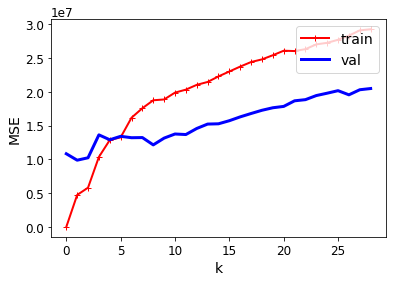

In [8]:
plot_training_vs_validation(train_split_x,train_split_y,val_split_x,val_split_y) #training vs validation plot
plt.show() 

### b) Test your model:

In [9]:
best_knn = KNeighborsRegressor(n_neighbors=3) #re-creating best model as best_knn 3 or 4 can be best knn I selected 3
best_knn.fit(train_x_e, train_y) #training best_knn

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                    weights='uniform')

In [10]:
knn_preds = best_knn.predict(test_x)

In [11]:
knn_mse = mean_squared_error(test_y , knn_preds)
print(knn_mse) #test MSE on the test set

19032660.224483024


## DECISION TREE REGRESSOR TO PREDICT CAR PRICES

### c) Grid Search to find best model:

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor() #Decision Tree model
param_tree = [{'max_depth': [None, 1, 5, 10], 'min_samples_split': [0.01, 0.05, 0.1, 0.3],'max_features':['auto', 'sqrt', 'log2'],'max_leaf_nodes':[10, 50, 100, 250],'random_state':[0]}]
decision_tree_grid = GridSearchCV(tree_reg, param_tree, cv=5,scoring="neg_mean_squared_error",return_train_score=True)
decision_tree_grid.fit(train_x_e, train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=None,
                                             splitter='best'),
             iid='warn', n_jobs=None,
             param_grid=[{'max_depth': [None, 1, 5, 10],
                          'max_features': ['auto', 'sqrt', 'log2'],
                          'max_leaf_nodes': [10, 50, 100, 250],
                       

In [13]:
decision_tree_grid.best_params_ #best parameters

{'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': 50,
 'min_samples_split': 0.1,
 'random_state': 0}

In [14]:
decision_tree_grid_mse = -(decision_tree_grid.best_score_)
print(decision_tree_grid_mse) #obtaining MSE

11321462.259990446


### d) Test your model:

In [15]:
#recreating your best Decision Tree model
best_tree = DecisionTreeRegressor(max_depth= None, max_features='auto',max_leaf_nodes=50,min_samples_split= 0.1,random_state= 0) #recreating the model using the best parameters in (n)
best_tree.fit(train_x_e, train_y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
                      max_leaf_nodes=50, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=0.1, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=0, splitter='best')

In [16]:
tree_preds = best_tree.predict(test_x) #getting predictions

In [17]:
tree_mse = mean_squared_error(test_y, tree_preds) #testing MSE on the test set
print(tree_mse)

15970311.088158127


## ENSEMBLE BAGGING REGRESSOR TO PREDICT CAR PRICES

### e) Grid Search to find best model:

In [18]:
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression

bagg_reg = BaggingRegressor() #Bagging Regressor model
params_bag = [{"base_estimator":[LinearRegression(),KNeighborsRegressor(),DecisionTreeRegressor(random_state=0)],"n_estimators": [25, 50, 100, 250],"bootstrap_features": [False,True],'random_state':[0]}]
bag_grid = GridSearchCV(bagg_reg, param_grid=params_bag,cv=5,scoring="neg_mean_squared_error",return_train_score=True)
bag_grid.fit(train_x_e, train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=BaggingRegressor(base_estimator=None, bootstrap=True,
                                        bootstrap_features=False,
                                        max_features=1.0, max_samples=1.0,
                                        n_estimators=10, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'base_estimator': [LinearRegression(copy_X=True,
                                                              fit_int...
                                                                   min_impurity_decrease=0.0,
                                                                   min_impurity_split=None,
                                                                   min_samples_leaf=1,
                                                       

In [19]:
bag_grid.best_params_ #best parameters

{'base_estimator': DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort=False, random_state=0, splitter='best'),
 'bootstrap_features': True,
 'n_estimators': 25,
 'random_state': 0}

In [20]:
bag_grid_mse = -(bag_grid.best_score_)
print(bag_grid_mse) #obtaining MSE

7703546.354830528


### f) Test your model:

In [21]:
#Recreating your best Ensemble Bagging model
best_bag = BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort=False, random_state=0, splitter='best'),bootstrap_features=True,n_estimators=25,random_state=0)
best_bag.fit(train_x_e, train_y)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                      max_depth=None,
                                                      max_features=None,
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      presort=False,
                                                      random_state=0,
                                                      splitter='best'),
                 bootstrap=True, bootstrap_features=True, max_features=1.0,
                 max_samples=1.

In [22]:
bag_preds = best_bag.predict(test_x) #getting predictions

In [23]:
bag_mse = mean_squared_error(test_y,bag_preds) #testing MSE on the test set.
print(bag_mse)

5796232.42420016


## RANDOM FOREST REGRESSOR TO PREDICT CAR PRICES

### g) Grid Search to find best model:

In [24]:
from sklearn.ensemble import RandomForestRegressor

randomForest_reg = RandomForestRegressor() #Random Forest model
param_RF = [{'n_estimators': [25, 50, 100, 250], 'max_depth': [None, 1, 5, 10],'random_state':[0]}]
random_forest_grid = GridSearchCV(randomForest_reg,param_RF,cv=5,scoring="neg_mean_squared_error",return_train_score=True)
random_forest_grid.fit(train_x_e, train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_depth': [None, 1, 5, 10],

In [25]:
random_forest_grid.best_params_ #best model’s parameters 

{'max_depth': 10, 'n_estimators': 250, 'random_state': 0}

In [26]:
random_forest_grid_mse = -(random_forest_grid.best_score_) #model's mse error.
print(random_forest_grid_mse) 

8766194.653429836


### h) Test your model:

In [27]:
#Recreating your best Random Forest model
best_random_forest = RandomForestRegressor(max_depth=10,n_estimators=250,random_state=0)
best_random_forest.fit(train_x_e, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=250,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [28]:
random_forest_preds = best_random_forest.predict(test_x) #getting predictions

In [29]:
random_forest_mse = mean_squared_error(test_y,random_forest_preds) #getting mse error
print(random_forest_mse)

5677265.139094966


### i) Feature Importances:

In [30]:
feature_importances = pd.DataFrame(best_random_forest.feature_importances_,index = train_x_e.columns,columns=['importance']).sort_values('importance',ascending=False)
top_3_rf_features = feature_importances.index[:3].tolist()
print(top_3_rf_features) #Print out the three most important features according to your best model.

['enginesize', 'curbweight', 'highwaympg']


In [31]:
top_3_rf_features = best_random_forest.feature_importances_[:3] #in the book I saw this..
print(top_3_rf_features)

[0.02918598 0.0347361  0.03522646]
